# Apple Disease Classification

### Import Required Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import random
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from re import search
import shutil
import natsort
from PIL import Image
from tqdm import tqdm
import pickle

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing import image

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Define Path 
MAIN_PATH = os.getcwd()
DATA_DIR = os.path.join(os.getcwd(),'plant-pathology-2020-fgvc7')
IMAGE_DIR = os.path.join(DATA_DIR, 'images')
# Image Size for Data Generator
IMG_SIZE = 224
# Batch Size
BATCH_SIZE = 16
# Epochs
EPOCHS = 50

### Load Data

In [3]:
# Train dataset
train_df = pd.read_csv("./plant-pathology-2020-fgvc7/train.csv")
# Test dataset
test_df = pd.read_csv("./plant-pathology-2020-fgvc7/test.csv")

In [4]:
# lets check the glimpse of first five rows of train dataset
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [5]:
# category - for each image_id 
def convert_dummies_to_category(df):
    data = df.copy()
    s2 = data[['healthy','multiple_diseases','rust','scab']].idxmax(axis=1)
    data = pd.concat([data,s2],axis=1)
    data.rename({0:'category'},axis=1,inplace=True)
    return data
  
# apply above function to find the category of the image
train_df = convert_dummies_to_category(train_df)
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab,category
0,Train_0,0,0,0,1,scab
1,Train_1,0,1,0,0,multiple_diseases
2,Train_2,1,0,0,0,healthy
3,Train_3,0,0,1,0,rust
4,Train_4,1,0,0,0,healthy


In [6]:
def get_img_label(img):
    ''' function to fetch the category of the image'''
    if search("Train",img):
        img = img.split('.')[0]
        category = train_df.loc[train_df['image_id']==img]['category']
        return category

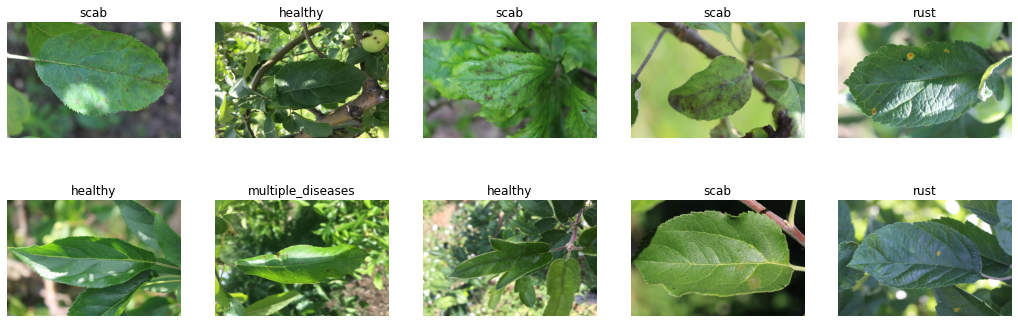

In [7]:
# lets check some images 
random_images = random.sample(glob.glob(os.path.join(IMAGE_DIR,"Train_*.jpg")),10)
random_id = [img_path.split('\\')[-1] for img_path in random_images]
# random_id = [img_path.split('/')[-1] for img_path in random_images]   # use this if above random_id code is not working

plt.figure(figsize=(18, 6))
for idx, img_path in enumerate(random_id):
    img_title = get_img_label(img_path)
    sp = plt.subplot(2, 5, idx+1)
    sp.axis('Off')
    complete_path = os.path.join(IMAGE_DIR,img_path)
    mp_image = mpimg.imread(complete_path)
    plt.title(img_title.values[0])
    plt.imshow(mp_image) 

### Data Preparation

In [8]:
# data labels - Target  
labels = train_df.loc[:,'healthy':].columns
print(labels)

# save the labels for deployment purpose
pickle.dump(labels,open('labels.pkl','wb'))

Index(['healthy', 'multiple_diseases', 'rust', 'scab', 'category'], dtype='object')


In [9]:
# lets separate the images into separate folders according to their labels
def create_image_dir_labels():
    # sort the filenames in IMAGE_DIR
    images = natsort.natsorted(os.listdir(IMAGE_DIR))
    for img in tqdm(images):
        # function to fetch the label of the image
        label = get_img_label(img)
        # image path from the original image dir
        image_path = os.path.join(IMAGE_DIR,img)
        
        if search("Train",img):
            # if image label is equal to healthy, copy that image into healthy directory.
            if (img.split("_")[1].split(".")[0]) and label.item()=='healthy':
                shutil.copy(image_path, os.path.join(DATA_DIR,'train','healthy'))
             
            # if image label is equal to multiple_diseases, copy that image into multiple_diseases directory.
            elif(img.split("_")[1].split(".")[0]) and label.item()=='multiple_diseases':
                shutil.copy(image_path,os.path.join(DATA_DIR,'train','multiple_diseases'))
               
            # if image label is equal to rust, copy that image into rust directory.
            elif(img.split("_")[1].split(".")[0]) and label.item()=='rust':
                shutil.copy(image_path,os.path.join(DATA_DIR,'train','rust'))
             
            # if image label is equal to scab, copy that image into scab directory.
            elif(img.split("_")[1].split(".")[0]) and label.item()=='scab':
                shutil.copy(image_path,os.path.join(DATA_DIR,'train','scab'))
         
        # else copy all excluded images from the above conditions into test directory.
        elif search("Test",img):
            shutil.copy(image_path,os.path.join(DATA_DIR,'test'))

In [10]:
# create directory for train - healthy, multiple_diseases, rust, scab and test images
try:
    shutil.os.mkdir(os.path.join(DATA_DIR, 'train'))
    shutil.os.mkdir(os.path.join(DATA_DIR,'train','healthy'))
    shutil.os.mkdir(os.path.join(DATA_DIR,'train','multiple_diseases'))
    shutil.os.mkdir(os.path.join(DATA_DIR,'train','rust'))
    shutil.os.mkdir(os.path.join(DATA_DIR,'train','scab'))

    shutil.os.mkdir(os.path.join(DATA_DIR, 'test'))
    print('Folders Created Successfully!!')
except:
    print('Folders Already Exists!!')

Folders Created Successfully!!


In [11]:
# Apply function to copy images belongs to their respective category
create_image_dir_labels()

100%|██████████████████████████████████████████████████████████████████████████████| 3642/3642 [00:50<00:00, 71.80it/s]


### Data Augmentation

In [12]:
# All images will be rescaled by 1.0/255
datagen=ImageDataGenerator(rescale=1.0/255,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True,
                                validation_split=0.2)

# Path - Train Directory 
Train_DIR = os.path.join(DATA_DIR, 'train')

# Flow training images in batches of 16 using datagen generator
train_datagen=datagen.flow_from_directory(Train_DIR,
                                         target_size=(IMG_SIZE,IMG_SIZE),
                                         batch_size=BATCH_SIZE,
                                         class_mode='categorical',
                                         subset='training')

# Flow validation images in batches of 16 using datagen generator
val_datagen=datagen.flow_from_directory(Train_DIR,
                                         target_size=(IMG_SIZE,IMG_SIZE),
                                         batch_size=BATCH_SIZE,
                                         class_mode='categorical',
                                         subset='validation')

Found 1458 images belonging to 4 classes.
Found 363 images belonging to 4 classes.


### Model Building

In [13]:
# Formation of CNN model

model=Sequential()
# Note the input shape is the desired size of the image 224x224 with 3 color
model.add(Conv2D(64,(3,3),activation='relu',padding='same',input_shape=(IMG_SIZE,IMG_SIZE,3)))
# Max Pooling Layer
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
# Flatten the results to feed into a DNN
model.add(Flatten())
# 4 output neuron because of 4 labels in output layer
model.add(Dense(4,activation='softmax'))

# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       7

### Defining Callbacks

In [14]:
# Checkpoint to save the best model on the basis of validation loss
checkpoint=ModelCheckpoint('./best_weights.h5',
                          monitor='val_loss',
                          mode='min',
                          save_best_only=True,
                          verbose=1)
# Early Stop - if the number of epochs that is 10 without improvement of validation loss after which training will be early stopped.
earlystop=EarlyStopping(monitor='val_loss',
                       min_delta=0,
                       patience=10,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]

### Model Training

In [15]:
history = model.fit(train_datagen,validation_data=val_datagen,
                                 epochs=EPOCHS,
                                 steps_per_epoch=train_datagen.samples//BATCH_SIZE,
                                 validation_steps=val_datagen.samples//BATCH_SIZE,
                                 callbacks=callbacks)

Epoch 1/50
91/91 [==============================] - 300s 3s/step - loss: 1.2710 - accuracy: 0.3114 - val_loss: 1.2470 - val_accuracy: 0.3324

Epoch 00001: val_loss improved from inf to 1.24703, saving model to .\best_weights.h5
Epoch 2/50
91/91 [==============================] - 269s 3s/step - loss: 1.2509 - accuracy: 0.3377 - val_loss: 1.2660 - val_accuracy: 0.3295

Epoch 00002: val_loss did not improve from 1.24703
Epoch 3/50
91/91 [==============================] - 262s 3s/step - loss: 1.2151 - accuracy: 0.4182 - val_loss: 1.0854 - val_accuracy: 0.5028

Epoch 00003: val_loss improved from 1.24703 to 1.08544, saving model to .\best_weights.h5
Epoch 4/50
91/91 [==============================] - 263s 3s/step - loss: 0.9589 - accuracy: 0.5978 - val_loss: 0.7165 - val_accuracy: 0.7301

Epoch 00004: val_loss improved from 1.08544 to 0.71651, saving model to .\best_weights.h5
Epoch 5/50
91/91 [==============================] - 266s 3s/step - loss: 0.7482 - accuracy: 0.6976 - val_loss: 0.68


Epoch 00039: val_loss did not improve from 0.20413
Epoch 40/50
91/91 [==============================] - 261s 3s/step - loss: 0.2696 - accuracy: 0.9147 - val_loss: 0.2684 - val_accuracy: 0.9148

Epoch 00040: val_loss did not improve from 0.20413
Epoch 41/50
91/91 [==============================] - 265s 3s/step - loss: 0.1654 - accuracy: 0.9487 - val_loss: 0.2390 - val_accuracy: 0.9318

Epoch 00041: val_loss did not improve from 0.20413
Epoch 42/50
91/91 [==============================] - 261s 3s/step - loss: 0.1430 - accuracy: 0.9528 - val_loss: 0.2674 - val_accuracy: 0.9261

Epoch 00042: val_loss did not improve from 0.20413
Epoch 43/50
91/91 [==============================] - 278s 3s/step - loss: 0.1412 - accuracy: 0.9535 - val_loss: 0.2654 - val_accuracy: 0.9091

Epoch 00043: val_loss did not improve from 0.20413
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping


### Result

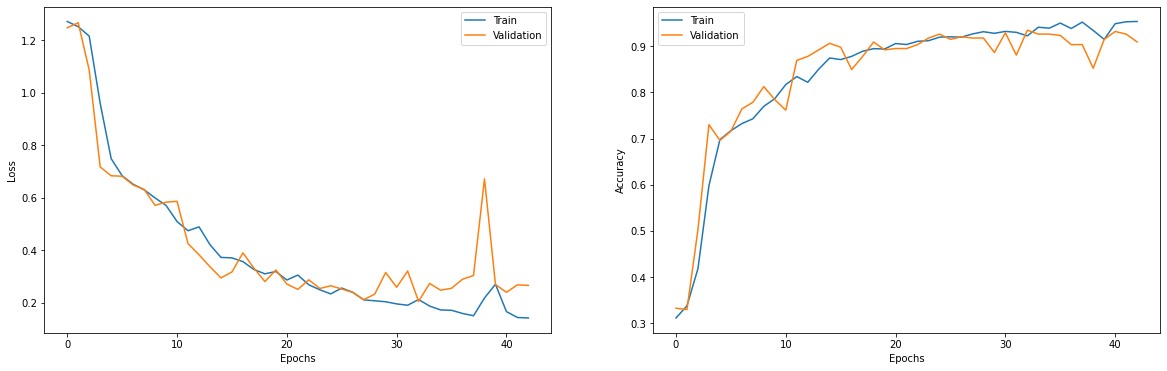

In [16]:
plt.figure(1, figsize = (20, 6))

plt.subplot(121)
plt.plot(history.history['loss'], label = 'Train')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


### Prediction

In [17]:
def check_apple_leaf(image_name):
    DIR = os.path.join(IMAGE_DIR, image_name)
    image_result = Image.open(DIR)
    
    test_image = image.load_img(DIR,target_size=(IMG_SIZE,IMG_SIZE))
    test_image = image.img_to_array(test_image)
    test_image = test_image/255
    test_image = np.expand_dims(test_image,axis=0)
    result = model.predict(test_image)

    Categories = ['healthy','multiple_disease','rust','scab']
    image_result = plt.imshow(image_result)
    plt.title(Categories[np.argmax(result)])
    plt.show()
    

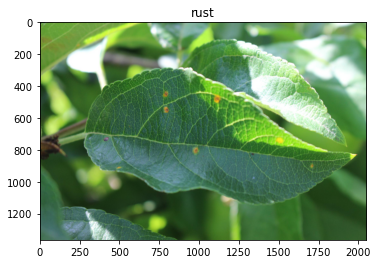

In [18]:
check_apple_leaf('Test_1002.jpg')

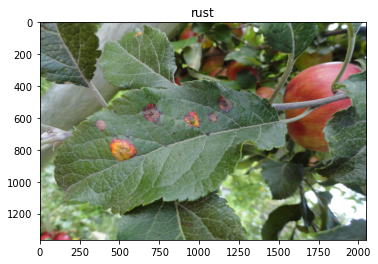

In [19]:
check_apple_leaf('Test_1010.jpg')

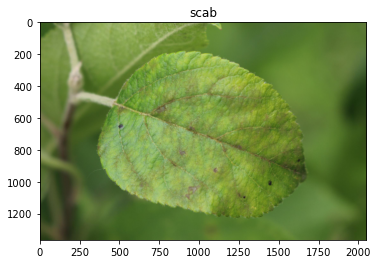

In [20]:
check_apple_leaf('Test_1018.jpg')